In [1]:
# function to generate all the sub lists
from data_prep import load_movies_full_df, get_index_to_movieId
from recommendations import make_recommendations_dict
from test import load_testing_set, test_recommendations
from similarity import get_cosine_sim_matrix
from features import get_features, get_feature_count_matrix, make_soup
from overview_processing import get_lemmatized_tfidf_matrix

import numpy as np
from itertools import combinations


def sub_lists(my_list):
	subs = []
	for i in range(0, len(my_list)+1):
	  temp = [list(x) for x in combinations(my_list, i)]
	  if len(temp)>0:
	    subs.extend(temp)
	return subs


MIN_VOTES_PER_MOVIE = 50
NEUTRAL_RATING = 2.5
MIN_POSITIVE_VOTES_PER_USER = 20
DESIRED_COLUMNS = ['id', 'cast', 'title', 'crew',
                   'genres', 'overview', 'production_companies']


def append_to_analytics(mean_x_in_100, weight_features, weight_bow, n_train_movies):
    with open('analytics.csv', 'a') as f:
        f.write(
            f'{mean_x_in_100}, {weight_features}, {weight_bow}, {n_train_movies}\n')

# get the basic dataframe
# that has the desired features and that only keeps movies that are frequently watched (i.e. rated)
df = load_movies_full_df(
    movies_metadata_path='data/IMDB_Ratings/movies_metadata.csv',
    credits_path='data/IMDB_Ratings/credits.csv',
    n_votes=MIN_VOTES_PER_MOVIE,
    desired_columns=DESIRED_COLUMNS)

# get the tf-idf matrix of the overviews of the movies
# used by the base model
# get_lemmatized_tfidf_matrix(df['overview'])
lemmatized_tfidf_matrix = np.zeros((9171, 1))

# get the features of a movie to augment its data with it
df = get_features(
    df=df,
    features_names=['cast', 'crew', 'genres', 'production_companies'],
    feature_and_n=[
        ('cast', 5),
        ('genres', 3),
        ('production_companies', 2)
    ],
    make_soup=False
)

# TESTING

print('\n>> TESTING')

test_df = load_testing_set(
    ratings_file_path='data/IMDB_Ratings/ratings.csv',
    accepted_movieIds=df['id'].to_list(),
    neutral_rating=NEUTRAL_RATING,
    min_n_pos_ratings_per_user=MIN_POSITIVE_VOTES_PER_USER
)

# get recommendation matrix for fast testing
idx2id = get_index_to_movieId(df)

overview_weight = 0
feature_weight = 1
n_train_movies = 10



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641_cymourad_project\data_prep.py:20: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv(movies_metadata_path)
c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641_cymourad_project\data_prep.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enough_votes['overview'] = enough_votes['overview'].fillna('')


Preparing features ...
Parsing stringified objects into Python readable objects ...
Getting director names ...
Extracting top 5 cast ...
Extracting top 3 genres ...
Extracting top 2 production_companies ...

>> TESTING
Loading csv ...
Removings reviews for movies that did not have enough ratings ...
Removing all neutral and negative ratings ...
Finding active users ...
Grouping positive reviews per user ...


In [30]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        # Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

def join_features(x, features=['cast', 'genres', 'director', 'production_companies']):
    joined_features = ''
    for feature in features:
        clean_x = clean_data(x[feature])
        if feature == 'director':
            joined_features += clean_x + ' '
        else:
            joined_features += ' '.join(clean_x) + ' '
    return joined_features

def make_soup_(df, features_in_soup=['cast', 'genres', 'director', 'production_companies']):
    return df.apply(join_features, args=(features_in_soup,), axis=1)

make_soup_(df, features_in_soup=['director'])

0              johnlasseter 
1               joejohnston 
2              howarddeutch 
3              charlesshyer 
4               michaelmann 
                ...         
9166    philippedechauveron 
9167        jean-mariepoiré 
9168           shanevandyke 
9169              bethdavid 
9170              larryshaw 
Length: 9171, dtype: object

In [36]:
for feautre_combo_to_test in sub_lists(['director', 'cast', 'genres', 'production_companies']):
    if len(feautre_combo_to_test) == 0:
        continue
    print(f'\n >> Testing with {feautre_combo_to_test}.')

    # get a count-vectorized matrix of the features
    features_count_matrix = get_feature_count_matrix(
        make_soup_(df, features_in_soup=feautre_combo_to_test)
        # df['director'].apply(clean_data)
        )

    # construct a similarity matrix
    sim_mx = get_cosine_sim_matrix(
        lemmatized_tfidf_matrix, features_count_matrix, overview_weight, feature_weight)

    rec_dict = make_recommendations_dict(sim_mx, idx2id)

    # test the recommendations on the test users
    mean_x_in_100 = test_recommendations(
        user_ratings=test_df['moviesWatched'].to_list(),
        n_train_movies=n_train_movies,
        rec_dict=rec_dict
    )


 >> Testing with ['director'].
Making recommendations dictionary ...
Testing on 87592 users ...
Mean for 87592: 0.8685039729655676

 >> Testing with ['cast'].
Making recommendations dictionary ...
Testing on 87592 users ...
Mean for 87592: 0.9731938989862088

 >> Testing with ['genres'].
Making recommendations dictionary ...
Testing on 87592 users ...
Mean for 87592: 1.2906429810941638

 >> Testing with ['production_companies'].
Making recommendations dictionary ...
Testing on 87592 users ...
Mean for 87592: 0.840499132340853

 >> Testing with ['director', 'cast'].
Making recommendations dictionary ...
Testing on 87592 users ...
Mean for 87592: 1.4103913599415472

 >> Testing with ['director', 'genres'].
Making recommendations dictionary ...
Testing on 87592 users ...
Mean for 87592: 1.3216047127591561

 >> Testing with ['director', 'production_companies'].
Making recommendations dictionary ...
Testing on 87592 users ...
Mean for 87592: 1.0158576125673577

 >> Testing with ['cast', 'g

In [51]:
import pandas as pd
feature_importance_df = pd.read_csv("feature_importance.csv")
feature_importance_df

,feature_combo,hits_in_100
0,['director'],0.868504
1,['cast'],0.973194
2,['genres'],1.290643
3,['production_companies'],0.840499
4,"['director', 'cast']",1.410391
5,"['director', 'genres']",1.321605
6,"['director', 'production_companies']",1.015858
7,"['cast', 'genres']",1.127272
8,"['cast', 'production_companies']",0.856733
9,"['genres', 'production_companies']",0.936010


In [52]:
from sklearn.preprocessing import MultiLabelBinarizer
from features import parse_into_python_objects

feature_importance_df = parse_into_python_objects(feature_importance_df, ['feature_combo'])

# one-hot-encoding for the genres
mlb_features = MultiLabelBinarizer()

feature_importance_df = feature_importance_df.join(
    pd.DataFrame(
        mlb_features.fit_transform(feature_importance_df.pop('feature_combo')),
        columns=mlb_features.classes_,
        index=feature_importance_df.index
    )
)
feature_importance_df[mlb_features.classes_] = feature_importance_df[mlb_features.classes_].astype(bool)
feature_importance_df.head()

Parsing stringified objects into Python readable objects ...


,hits_in_100,cast,director,genres,production_companies
0,0.868504,False,True,False,False
1,0.973194,True,False,False,False
2,1.290643,False,False,True,False
3,0.840499,False,False,False,True
4,1.410391,True,True,False,False


In [55]:
list(mlb_features.classes_)

['cast', 'director', 'genres', 'production_companies']

In [56]:
test_df = feature_importance_df.set_index(list(mlb_features.classes_))
test_df.head()

hits_in_100
cast  director genres production_companies              
False True     False  False                     0.868504
True  False    False  False                     0.973194
False False    True   False                     1.290643
               False  True                      0.840499
True  True     False  False                     1.410391

In [62]:
test_df.columns

Index([' hits_in_100'], dtype='object')

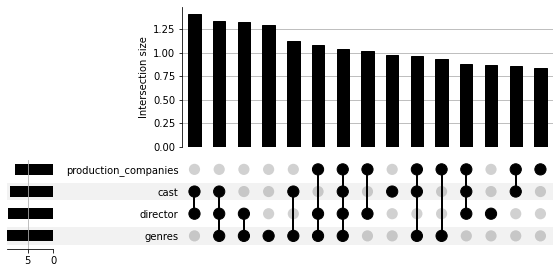

In [67]:
from upsetplot import UpSet
plt = UpSet(
    test_df, 
    subset_size='sum', 
    sum_over=' hits_in_100', 
    sort_by='cardinality',
).plot()